<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20-%20autoencoder%20-%20anomaly%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Автокодировщики для задач обнаружения аномалий

Автокодировщики могут быть полезны для задач обнаружения аномалий, так как они обучаются восстанавливать нормальные данные, а для аномальных данных ошибка восстановления будет значительно выше. Давайте напишем пример простой нейронной сети на базе автокодировщика.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Генерация синтетических данных
class SyntheticDataset(Dataset):
    def __init__(self, num_samples=1000, num_anomaly = 0.05):
        self.num_samples = num_samples
        # Нормальные данные (около нуля)
        self.data = np.random.randn(num_samples, 2)
        # Добавляем аномалии (num_anomaly = % точек вдали от нуля)
        num_anomalies = int(num_anomaly * num_samples)
        anomalies = np.random.uniform(low=0, high=8, size=(num_anomalies, 2))
        self.data[:num_anomalies] = anomalies

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

In [72]:
# Модель автокодировщика
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # Сжатое представление
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # Восстановление исходного размера
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [73]:
# Обучение модели на нормальных данных (исключая аномалии)
def train_model(model, dataloader, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            # Прямой проход
            outputs = model(batch)
            loss = criterion(outputs, batch)

            # Обратный проход и оптимизация
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}')

    print('Training complete.')

In [74]:
# Оценка аномалий с вычислением порога
def detect_anomalies(model, dataset, quantile=0.95):
    model.eval()
    reconstruction_errors = []
    with torch.no_grad():
        for sample in dataset:
            sample = sample.unsqueeze(0)
            output = model(sample)
            reconstruction_error = torch.mean((output - sample) ** 2).item()
            reconstruction_errors.append(reconstruction_error)

    # Устанавливаем порог на основе квантиля ошибок восстановления
    threshold = np.quantile(reconstruction_errors, quantile)
    print(f'threshold: {threshold:.4f}')

    # Определяем аномалии по порогу ошибки
    anomalies = np.where(np.array(reconstruction_errors) > threshold)[0]
    return anomalies, reconstruction_errors, threshold

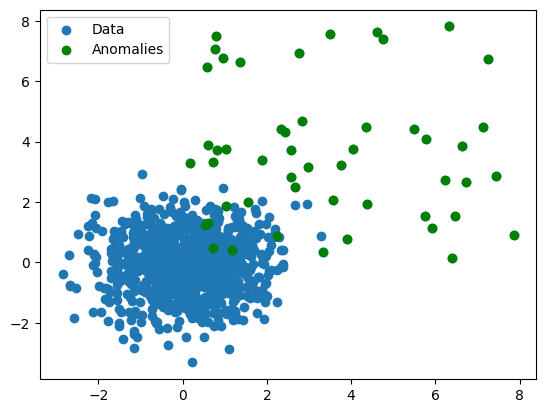

In [75]:
# Создаем набор данных
num_anomaly=0.05
dataset = SyntheticDataset(num_anomaly=num_anomaly)
plt.scatter(dataset[:, 0], dataset[:, 1], label='Data')

num_anomalies = int(len(dataset) * num_anomaly)

plt.scatter(dataset[:num_anomalies, 0], dataset[:num_anomalies, 1], color='g', label='Anomalies')
plt.legend()
plt.show()


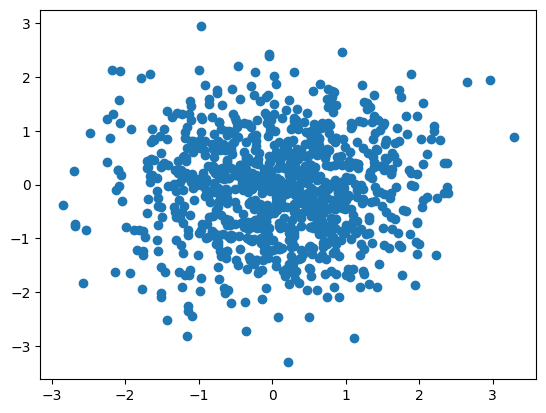

In [76]:
# Отбираем только нормальные данные для обучения
normal_data = dataset.data[int(num_anomaly * dataset.num_samples):]  # Исключаем первые 5% аномалий
normal_dataset = torch.tensor(normal_data, dtype=torch.float32)
plt.scatter(normal_dataset[:, 0], normal_dataset[:, 1], label='Data')

In [77]:
# Создаем DataLoader для нормальных данных
dataloader = DataLoader(normal_dataset, batch_size=32, shuffle=True)

- Обучение на нормальных данных: исключаем аномалии из тренировочного набора данных, используя только нормальные данные для обучения автокодировщика.

- Квантильный порог: Порог для обнаружения аномалий теперь вычисляется на основе 95-го процентиля ошибок восстановления, что позволит более гибко разделять нормальные данные и аномалии.

In [78]:
# Инициализация модели
model = Autoencoder()

# Обучение модели на нормальных данных
train_model(model, dataloader, epochs=100)

# Детектирование аномалий с порогом на основе 95% квантиля
anomalies, reconstruction_errors, threshold = detect_anomalies(model, dataset)

Epoch [1/100], Loss: 0.9350
Epoch [2/100], Loss: 0.8762
Epoch [3/100], Loss: 0.7838
Epoch [4/100], Loss: 0.6418
Epoch [5/100], Loss: 0.5070
Epoch [6/100], Loss: 0.4102
Epoch [7/100], Loss: 0.2768
Epoch [8/100], Loss: 0.1336
Epoch [9/100], Loss: 0.0830
Epoch [10/100], Loss: 0.0550
Epoch [11/100], Loss: 0.0376
Epoch [12/100], Loss: 0.0279
Epoch [13/100], Loss: 0.0213
Epoch [14/100], Loss: 0.0173
Epoch [15/100], Loss: 0.0142
Epoch [16/100], Loss: 0.0120
Epoch [17/100], Loss: 0.0102
Epoch [18/100], Loss: 0.0085
Epoch [19/100], Loss: 0.0075
Epoch [20/100], Loss: 0.0069
Epoch [21/100], Loss: 0.0059
Epoch [22/100], Loss: 0.0052
Epoch [23/100], Loss: 0.0047
Epoch [24/100], Loss: 0.0042
Epoch [25/100], Loss: 0.0038
Epoch [26/100], Loss: 0.0037
Epoch [27/100], Loss: 0.0035
Epoch [28/100], Loss: 0.0033
Epoch [29/100], Loss: 0.0028
Epoch [30/100], Loss: 0.0027
Epoch [31/100], Loss: 0.0025
Epoch [32/100], Loss: 0.0024
Epoch [33/100], Loss: 0.0022
Epoch [34/100], Loss: 0.0021
Epoch [35/100], Loss: 0

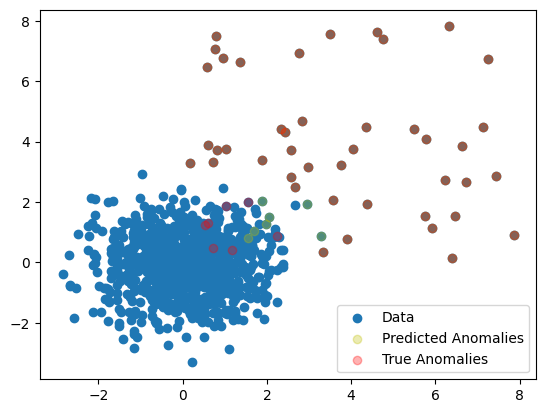

In [79]:
# Визуализация результатов
data = dataset.data
plt.scatter(data[:, 0], data[:, 1], label='Data')
plt.scatter(data[anomalies, 0], data[anomalies, 1], color='y', label='Predicted Anomalies', alpha=0.3)

num_anomalies = int(len(dataset) * num_anomaly)
plt.scatter(dataset[:num_anomalies, 0], dataset[:num_anomalies, 1], color='r', label='True Anomalies', alpha=0.3)

plt.legend()
plt.show()

